In [10]:
import json 
from dataclasses import dataclass 
import pandas as pd 
import matplotlib.pyplot as plt 

In [90]:
@dataclass
class ModelData:
    model_name: str 
    model_path: str 
    is_instr: bool 
    is_reinit: bool 
    is_full: bool 
    model_size: str 
    prediction: str 
    label: str 
    correct: bool 
    qlora: bool 

In [91]:
def check_score(text, label):
    other_label = '0' if label == '1' else '1'
    label_char = 'A' if label == '0' else 'B'
    other_label_char = 'B' if label == '0' else 'A'
    if f'{label}.' in text or f' {label}' in text.lower() or f'{label}' == text.strip() or f'\n{label}' in text.lower() or text.startswith(label) or text.strip().startswith(label_char):
        return 1
    elif f'{other_label}.' in text or f' {other_label}' in text.lower() or f'{other_label}' == text.strip() or f'\n{other_label}' in text.lower() or text.startswith(other_label) or text.strip().startswith(other_label_char):
        return 0
    elif str(label) == '0':
        if 'A.' in text:
            return 1 
    elif str(label) == '1':
        if 'B.' in text:
            return 1
    return None


In [112]:
models = ['llama-3.1-8b', 'llama-3.2-1b', 'qlora-llama-3.1-8b', 'qlora-llama-3.2-1b', 'qlora-llama-3.2-3b-instruct','qlora-llama-3.1-8b-instruct', 'qlora-llama-3.1-3b-instruct-full', '3b_qlora_single_device_instruct-reinit', 'llama-3.2-1b-instruct','llama-3.2-3b', 'llama-3.2-3b-instruct','llama-3.2-8b-instruct', 'qlora-llama-3.2-1b-instruct']

model_name_mapping = {
    'qlora-llama-3.1-8b-instruct': 'llama-3.1-8b',
    'qlora-llama-3.1-3b-instruct-full': 'llama-3.2-3b',
    'qlora-llama-3.2-1b': 'llama-3.2-1b',
    'qlora-llama-3.2-3b-instruct': 'llama-3.2-3b',
    '3b_qlora_single_device_instruct-reinit': 'llama-3.2-3b',
    'qlora-llama-3.1-8b-instruct': 'llama-3.1-8b',
    'qlora-llama-3.1-3b-instruct-full': 'llama-3.2-3b',
    'llama-3.1-8b': 'llama-3.1-8b',
    'llama-3.2-3b': 'llama-3.2-3b',
    'llama-3.2-1b': 'llama-3.2-1b',
    'qlora-llama-3.1-8b': 'llama-3.1-8b',
    'llama-3.2-8b-instruct': 'llama-3.1-8b',
    'llama-3.2-1b-instruct': 'llama-3.2-1b',
    'llama-3.2-3b-instruct': 'llama-3.2-3b',
    'qlora-llama-3.2-1b-instruct': 'llama-3.2-1b',
}


model_size_mapping = {
    'llama-3.1-8b': 8,
    'llama-3.2-1b': 1,
    'llama-3.2-3b': 3,
}

test_name = 'test.json'

data_list = []
for model in models:
    with open(f'../train_data/predictions/{model}/{test_name}', 'r') as f:
        data = json.load(f)
        for text, label in zip(data['predictions'], data['labels']):
            label = str(label)
            if model == '3b_qlora_single_device_instruct-reinit':
                is_reinit = True
                qlora = True
                is_instr = True
            elif model == 'qlora-llama-3.1-3b-instruct-full':
                is_full = True
                qlora = True
            else:
                is_reinit = False
                is_full = False
                qlora = 'qlora' in model
            model_name = model_name_mapping[model]  
            model_size = model_size_mapping[model_name]
            data_list.append(ModelData(model_name=model_name, model_path=model, is_instr=model.endswith('instruct'), model_size=model_size, prediction=text, label=label, correct=check_score(text, label), is_reinit=is_reinit, is_full=is_full, qlora=qlora))




In [113]:
keys = ['model_name', 'is_instr', 'is_reinit', 'is_full']
# model size effect 

In [114]:
df = pd.DataFrame(data_list)
df['correct'] = df['correct'].fillna('none')
only_ans = df[df['correct']!='none']

<Axes: xlabel='model_name,is_instr'>

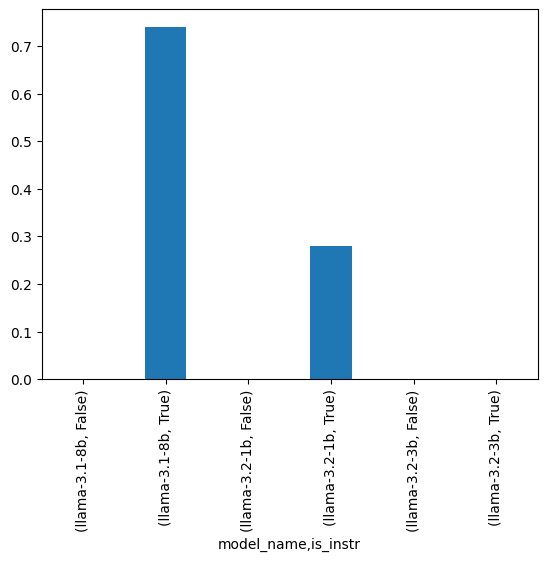

In [115]:
df['is_error'] = df['correct'] == 'none'
df[(df['qlora'] == False) & (df['is_full'] == False) & (df['is_reinit'] == False)].groupby(['model_name','is_instr'])['is_error'].mean().plot(kind='bar')

<Axes: xlabel='model_path,correct'>

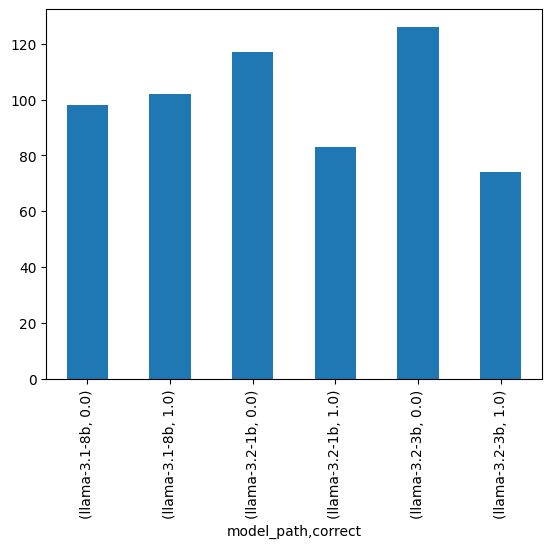

In [116]:
zero_shot = df[(df['is_instr']==False) & (df['is_full']==False) & (df['is_reinit']==False) & (df['qlora']==False)]
zero_shot.groupby(['model_path','correct'])['correct'].count().plot(kind='bar')



In [102]:
is_instr = df[(df['is_instr']==True) & (df['is_full']==False) & (df['is_reinit']==False) & (df['qlora']==True)]

<Axes: xlabel='model_name,correct'>

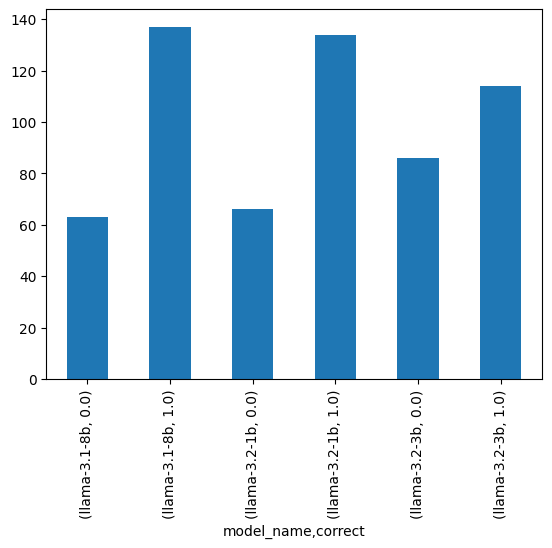

In [103]:
is_instr.groupby(['model_name','correct'])['correct'].count().plot(kind='bar')

<Axes: xlabel='model_name'>

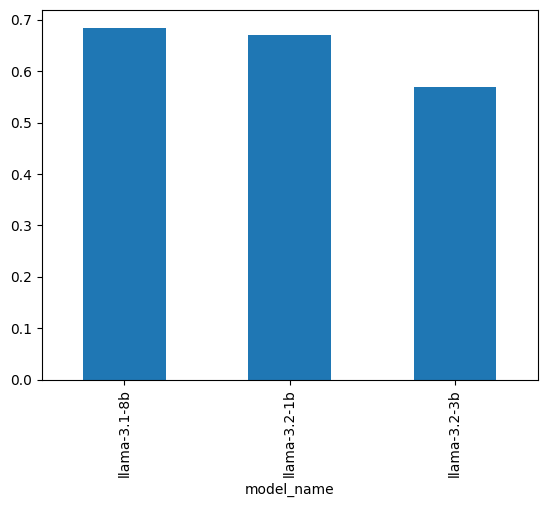

In [105]:

is_instr[is_instr['correct']!='none'].groupby(['model_name'])['correct'].mean().plot(kind='bar')
# plt.title('Instr vs Base, when gives an output')


In [106]:
is_instr = df[(df['is_instr']==True) & (df['is_full']==False) & (df['is_reinit']==False)]
is_instr.groupby(['model_name', 'qlora','correct'])['correct'].count()

model_name    qlora  correct
llama-3.1-8b  False  0.0         42
                     1.0         10
                     none       148
              True   0.0         63
                     1.0        137
llama-3.2-1b  False  0.0         64
                     1.0         80
                     none        56
              True   0.0         66
                     1.0        134
llama-3.2-3b  False  0.0        107
                     1.0         93
              True   0.0         86
                     1.0        114
Name: correct, dtype: int64

<Axes: xlabel='model_name,qlora,correct'>

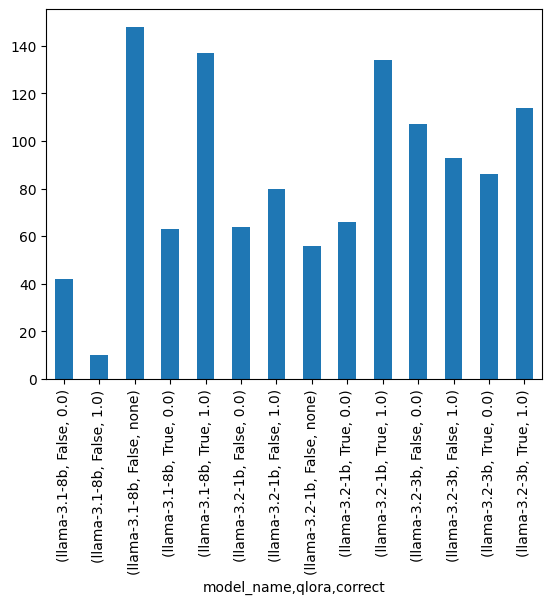

In [107]:
# compare without finetuning 
is_instr = df[(df['is_instr']==True) & (df['is_full']==False) & (df['is_reinit']==False)]
is_instr.groupby(['model_name','qlora','correct'])['correct'].count().plot(kind='bar')

<Axes: xlabel='model_name,is_instr'>

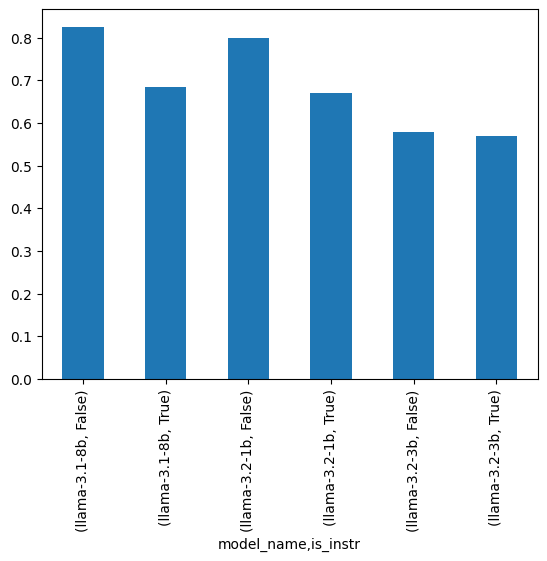

In [108]:
base_it = df[(df['qlora']==True) & (df['is_full']==False) & (df['is_reinit']==False)]
base_it.groupby(['model_name','is_instr'])['correct'].mean().plot(kind='bar')


In [82]:
# full vs not full
full_mean = df[df['is_full'] == True]['correct'].mean()
not_full_mean = df[(df['is_full'] == False) & (df['is_instr']==True) & (df['qlora']==True) & (df['is_reinit']==False) & (df['model_size']==3)]['correct'].mean()

In [83]:
print(f'Full mean: {full_mean}, Not full mean: {not_full_mean}')

Full mean: 0.65, Not full mean: 0.57


In [118]:
df[df['is_reinit'] == True]['correct'].mean()

0.58

In [119]:
df[(df['is_reinit'] == False) & (df['is_full'] == False) & (df['is_instr'] == True) & (df['qlora'] == True) & (df['model_size'] == 3)]['correct'].mean()

0.57